In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV,train_test_split, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score,recall_score,precision_score, classification_report,ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier



from sklearn import set_config

In [2]:
set_config(transform_output='pandas')

## Import the dataset

In [3]:
df = pd.read_csv('../data/preprocessed_predictive_maintenance.csv')
df.head()

,type,air_temperature,process_temp,rotational_speed_[rpm],torque_[nm],tool_wear_[min],target,failure_type
0,M,298.1,308.6,1551,42.8,0,0,no failure
1,L,298.2,308.7,1408,46.3,3,0,no failure
2,L,298.1,308.5,1498,49.4,5,0,no failure
3,L,298.2,308.6,1433,39.5,7,0,no failure
4,L,298.2,308.7,1408,40.0,9,0,no failure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   type                    10000 non-null  object 
 1   air_temperature         10000 non-null  float64
 2   process_temp            10000 non-null  float64
 3   rotational_speed_[rpm]  10000 non-null  int64  
 4   torque_[nm]             10000 non-null  float64
 5   tool_wear_[min]         10000 non-null  int64  
 6   target                  10000 non-null  int64  
 7   failure_type            10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


### Split the data

In [5]:
X = df.drop(columns= ['failure_type','target' ], axis=1)
y = df['target']



X_train,X_test,Y_train,Y_test = train_test_split(X,y, stratify=y,  test_size=0.2,random_state=42 )

In [6]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_test: ', Y_test.shape)


X_train:  (8000, 6)
X_test:  (2000, 6)
Y_train:  (8000,)
Y_test:  (2000,)


In [7]:
Y_train.value_counts(normalize=True)

target
0    0.966125
1    0.033875
Name: proportion, dtype: float64

In [8]:
Y_test.value_counts(normalize=True)

target
0    0.966
1    0.034
Name: proportion, dtype: float64

## Define the Categorical Transformer

In [9]:
cat_transformer = ColumnTransformer(
    [
        (
            'cat_encoder',
              OneHotEncoder(sparse_output=False, drop='if_binary'),
               [ 'type'],
        )
       
    ],
    remainder ='passthrough',
    verbose_feature_names_out=False,
)

### Define the utility functions and tables

In [10]:
def get_errors(model,X,y):

    preds = model.predict(X)
    accuracy = accuracy_score(y,preds)
    recall = recall_score(y,preds)
    precision = precision_score(y,preds, zero_division=0.0)

    return {"accuracy ": accuracy , "recall ": recall, "precision ": precision}


def get_avg_cv_errors(cv_result):
    return{
        'accuracy ': cv_result['test_accuracy '].mean(),
        'recall ': cv_result['test_recall '].mean(),
        'precision ': cv_result['test_precision '].mean()


    }


def plot_confusion_matrix(model,model_name,X,y , split='test'):

    ConfusionMatrixDisplay.from_estimator(model, X, y )   
    plt.title(f'Confusion matrix of {model_name} model [{split.title()} set]')

def log_errors(model_name, errors, eval_set, perf_df):
    cols = [eval_set + "_" + err for err in ('accuracy', 'recall' , 'precision')]
    perf_df.loc[model_name,cols] = list(errors)

In [11]:
perf_df = pd.DataFrame(
    columns=[
        "train_accuracy",
        "train_recall",
        "train_precision",
        "cv_accuracy",
        "cv_recall",
        "cv_precision",
        "test_accuracy",
        "test_recall",
        "test_precision"
    ]
)

## Build and Evaluate Baseline Model

In [12]:
base_model = DummyClassifier()
base_model.fit(X_train,Y_train)

,strategy,'prior'
,random_state,None
,constant,None


In [13]:
base_train_pred = base_model.predict(X_train)

base_train_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
base_train_error = get_errors(base_model,X_train,Y_train)
base_train_error

{'accuracy ': 0.966125, 'recall ': 0.0, 'precision ': 0.0}

In [15]:
log_errors('Base_model',base_train_error.values(), 'train', perf_df)

In [16]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Get cross val errors

In [17]:
base_cross_val = cross_validate(base_model,X_train,Y_train, cv=5, scoring=get_errors)
base_cross_val

{'fit_time': array([0.01039934, 0.01564312, 0.01310611, 0.00757933, 0.        ]),
 'score_time': array([0.01711917, 0.01582932, 0.03140569, 0.02285409, 0.02675939]),
 'test_accuracy ': array([0.96625 , 0.96625 , 0.96625 , 0.96625 , 0.965625]),
 'test_recall ': array([0., 0., 0., 0., 0.]),
 'test_precision ': array([0., 0., 0., 0., 0.])}

In [18]:
base_avg_cross_val = get_avg_cv_errors(base_cross_val)
base_avg_cross_val

{'accuracy ': np.float64(0.9661250000000001),
 'recall ': np.float64(0.0),
 'precision ': np.float64(0.0)}

In [19]:
log_errors('Base_model' ,base_avg_cross_val.values(), "cv" ,perf_df)
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,NaN,NaN,NaN


### Evaluate base_model on test set 

In [20]:
base_test_pred = base_model.predict(X_test)

In [21]:
base_test_errors = get_errors(base_model,X_test,Y_test)
base_test_errors

{'accuracy ': 0.966, 'recall ': 0.0, 'precision ': 0.0}

### Save model error 

In [22]:
log_errors('Base_model', base_test_errors.values(), 'test' , perf_df)
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0


### Plot base model confusion matrix

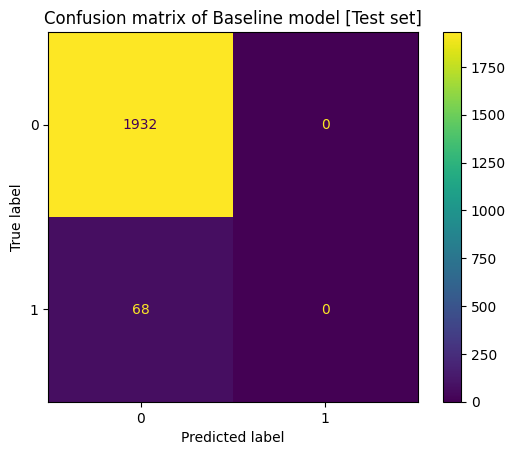

In [23]:
plot_confusion_matrix(base_model,'Baseline' ,X_test, Y_test)

## Build and Evaluate Logistic Model

**Drop multi correlated column**

In [24]:
## **This is to drop Multicollinearity columns


num_cols = ['air_temperature','torque_[nm]','tool_wear_[min]']
cat = ['type']
feat = X[num_cols + cat ].columns.to_list()
feat

['air_temperature', 'torque_[nm]', 'tool_wear_[min]', 'type']

In [25]:
lg_model  = LogisticRegression(max_iter=1000)

In [26]:
lg_pipeline = make_pipeline(cat_transformer,lg_model)

### Train the model

In [27]:
lg_pipeline.fit(X_train[feat],Y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Evaluate model on train set 

In [28]:
lg_train_pred = lg_pipeline.predict(X_train[feat])
lg_train_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
lg_train_error = get_errors(lg_pipeline,X_train[feat],Y_train)
lg_train_error

{'accuracy ': 0.968125,
 'recall ': 0.06273062730627306,
 'precision ': 0.9444444444444444}

### get lg cv error

In [30]:
lg_cv_error = cross_validate(lg_pipeline,X_train[feat],Y_train,cv=5,scoring=get_errors)
lg_cv_error

{'fit_time': array([0.39492297, 0.5268507 , 0.44765878, 0.34239984, 0.34994078]),
 'score_time': array([0.08067179, 0.05917358, 0.03969145, 0.03333998, 0.03337479]),
 'test_accuracy ': array([0.968125, 0.9675  , 0.969375, 0.9675  , 0.9675  ]),
 'test_recall ': array([0.05555556, 0.03703704, 0.09259259, 0.03703704, 0.05454545]),
 'test_precision ': array([1., 1., 1., 1., 1.])}

In [31]:
avg_cv_error = get_avg_cv_errors(lg_cv_error)
avg_cv_error

{'accuracy ': np.float64(0.968),
 'recall ': np.float64(0.055353535353535356),
 'precision ': np.float64(1.0)}

## Evaluate lg model on test set

In [32]:
lg_test_pred = lg_pipeline.predict(X_test)

In [33]:
lg_test_error = get_errors(lg_pipeline,X_test[feat],Y_test)
lg_test_error

{'accuracy ': 0.9665,
 'recall ': 0.029411764705882353,
 'precision ': 0.6666666666666666}

### Log Errors

In [34]:
log_errors('Lg_Model', lg_test_error.values(),'test', perf_df)
log_errors('Lg_Model', avg_cv_error.values(),'cv', perf_df)
log_errors('Lg_Model', lg_train_error.values(),'train', perf_df)

In [35]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667


## LG model confusion matrix 

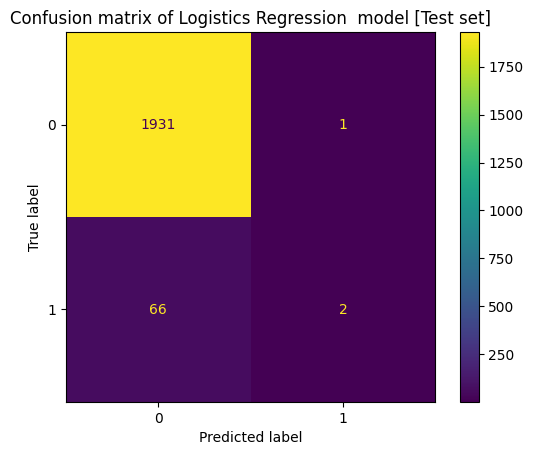

In [36]:
plot_confusion_matrix(lg_pipeline,'Logistics Regression ', X_test[feat],Y_test)

## Build and evaluate Decision Tree

In [37]:
dt_model = DecisionTreeClassifier(random_state=42)

In [38]:
dt_pipeline = make_pipeline(cat_transformer, dt_model)


In [39]:
dt_pipeline.fit(X_train,Y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [40]:
dt_pipeline[-1].get_depth()

19

### Find optimal  tree depth using grid search

In [41]:
dt_pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat_encoder',
                                   OneHotEncoder(drop='if_binary',
                                                 sparse_output=False),
                                   ['type'])],
                    verbose_feature_names_out=False)),
 ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))]

In [42]:
param_grid =  {'decisiontreeclassifier__max_depth': range(1,20)}
grid_search_cv = GridSearchCV(
    dt_pipeline,
    param_grid= param_grid,
    scoring= ['accuracy', 'recall' , 'precision'], refit='recall',
    return_train_score=True
)
grid_search_cv.fit(X_train,Y_train )

c:\Users\dunsin\OneDrive\Desktop\Sabi data analyst\Data Science\ds_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dunsin\OneDrive\Desktop\Sabi data analyst\Data Science\ds_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'decisiontreeclassifier__max_depth': range(1, 20)}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,None
,refit,'recall'
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat_encoder', ...)]"


In [43]:
cv_result = pd.DataFrame(grid_search_cv.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
0,0.060492,0.018581,0.118142,0.144169,1,{'decisiontreeclassifier__max_depth': 1},0.966250,0.968750,0.965625,0.971250,...,0.569810,0.310251,19,0.000000,0.836735,0.609756,0.853659,0.759259,0.611882,0.317849
1,0.045061,0.007337,0.043492,0.008019,2,{'decisiontreeclassifier__max_depth': 2},0.973125,0.973750,0.973125,0.972500,...,0.815259,0.066688,2,0.857143,0.870968,0.857143,0.848485,0.840580,0.854864,0.010143
2,0.066661,0.024444,0.061951,0.023830,3,{'decisiontreeclassifier__max_depth': 3},0.974375,0.973125,0.972500,0.970625,...,0.824722,0.071760,1,0.904110,0.888889,0.925373,0.980392,0.842857,0.908324,0.045091
3,0.062515,0.008228,0.034292,0.011278,4,{'decisiontreeclassifier__max_depth': 4},0.971875,0.973750,0.975625,0.973125,...,0.811590,0.075379,3,0.915888,0.866667,0.913043,0.984615,0.876712,0.911385,0.041443
4,0.028826,0.012782,0.017726,0.005522,5,{'decisiontreeclassifier__max_depth': 5},0.972500,0.974375,0.973750,0.974375,...,0.796042,0.090240,4,0.989796,1.000000,0.976190,0.860465,0.978947,0.961080,0.051010


In [44]:
cv_cols =  [
    'param_decisiontreeclassifier__max_depth',
    'mean_test_precision',
    'mean_test_accuracy',
    'mean_test_recall',
    'std_test_precision',
    'rank_test_precision',
    'mean_train_precision',
    'std_train_precision',
    
    'std_test_recall',
    'rank_test_recall',
    'std_train_recall',
    'mean_train_recall',
    
    'std_test_accuracy',
    'rank_test_accuracy',
    'std_train_accuracy',
    'mean_train_accuracy'

]

In [45]:
cv_result_subset =  cv_result[cv_cols].sort_values(['rank_test_recall', 'std_test_recall'])

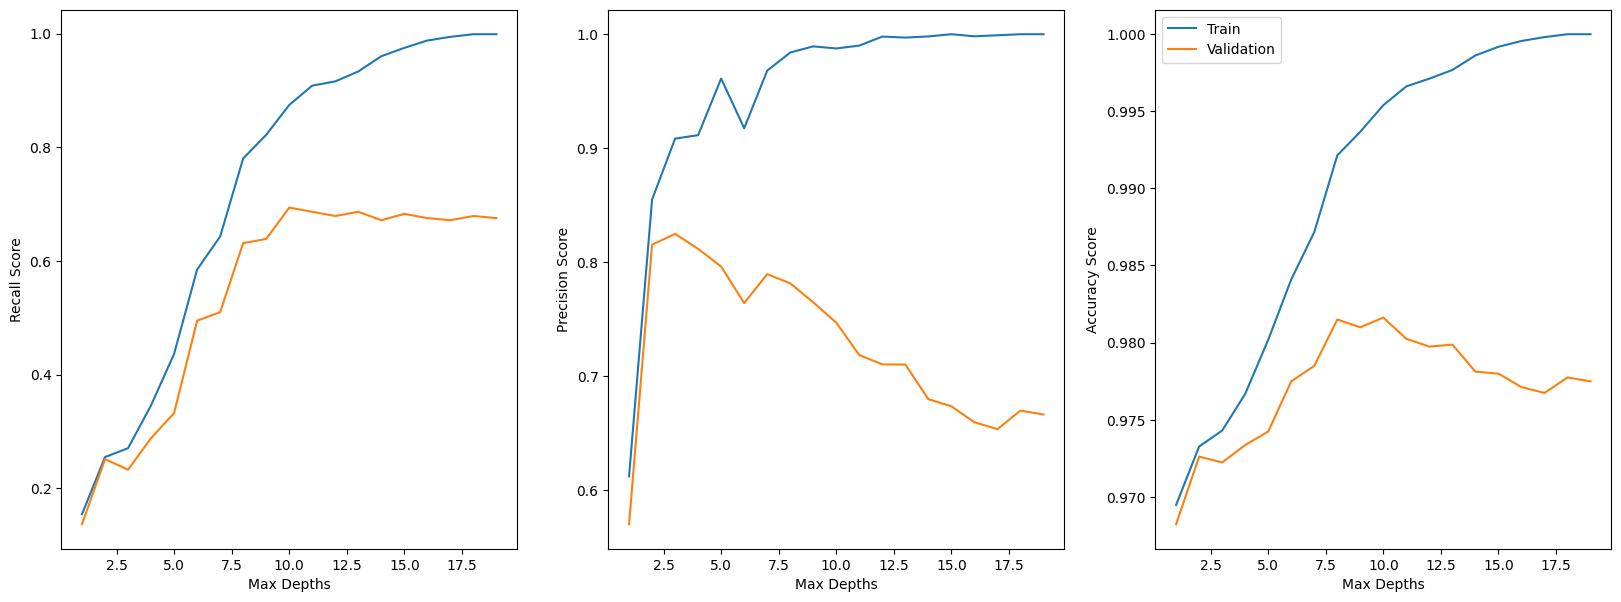

In [46]:
_, (ax1,ax2,ax3) = plt.subplots(1,3 , figsize=(20,7))
 
ax1.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_train_recall"], label="Train")
ax1.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_test_recall"], label="Validation")
ax1.set_xlabel("Max Depths")
ax1.set_ylabel("Recall Score")

ax2.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_train_precision"], label="Train")
ax2.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_test_precision"], label="Validation")
ax2.set_xlabel("Max Depths")
ax2.set_ylabel("Precision Score")

ax3.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_train_accuracy"], label="Train")
ax3.plot(cv_result["param_decisiontreeclassifier__max_depth"], cv_result["mean_test_accuracy"], label="Validation")
ax3.set_xlabel("Max Depths")
ax3.set_ylabel("Accuracy Score")
plt.legend()
plt.show()

In [47]:
cv_result_subset.set_index("param_decisiontreeclassifier__max_depth").loc[[7,8,9,10]].sort_values('mean_test_accuracy')

,mean_test_precision,mean_test_accuracy,mean_test_recall,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,std_test_recall,rank_test_recall,std_train_recall,mean_train_recall,std_test_accuracy,rank_test_accuracy,std_train_accuracy,mean_train_accuracy
param_decisiontreeclassifier__max_depth,,,,,,,,,,,,,,,
7,0.789384,0.978500,0.509697,0.054003,5,0.968025,0.020523,0.068472,13,0.031244,0.642934,0.001159,7,0.000666,0.987156
9,0.764608,0.981000,0.638653,0.037777,7,0.989348,0.011097,0.053359,11,0.034359,0.821911,0.001705,3,0.000961,0.993656
8,0.781321,0.981500,0.631246,0.024007,6,0.983936,0.011843,0.047330,12,0.015950,0.780419,0.001611,2,0.000538,0.992125
10,0.746796,0.981625,0.693805,0.018103,9,0.987500,0.007904,0.023959,1,0.024328,0.874505,0.000848,1,0.000893,0.995375


## Retrain the model with max depth 8

In [48]:
dt_model = DecisionTreeClassifier(max_depth=8 , random_state=42)

In [49]:
dt_pipeline = make_pipeline(cat_transformer, dt_model)
dt_pipeline.fit(X_train,Y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Evaluate the training set

In [50]:
dt_train_error = get_errors(dt_pipeline, X_train,Y_train)
dt_train_error

{'accuracy ': 0.990375,
 'recall ': 0.7380073800738007,
 'precision ': 0.970873786407767}

### Cross validate

In [51]:
dt_cv_errors = cross_validate(dt_pipeline,X_train,Y_train, scoring= get_errors , n_jobs=-1 , cv=5)
dt_cv_errors

{'fit_time': array([0.04538178, 0.04595685, 0.03482008, 0.04407239, 0.03608131]),
 'score_time': array([0.02111101, 0.02054548, 0.02099466, 0.02312732, 0.0190928 ]),
 'test_accuracy ': array([0.980625, 0.9825  , 0.983125, 0.9825  , 0.97875 ]),
 'test_recall ': array([0.61111111, 0.61111111, 0.68518519, 0.68518519, 0.56363636]),
 'test_precision ': array([0.76744186, 0.825     , 0.78723404, 0.77083333, 0.75609756])}

In [52]:
dt_ang_cv_error = get_avg_cv_errors(dt_cv_errors)
dt_ang_cv_error

{'accuracy ': np.float64(0.9814999999999999),
 'recall ': np.float64(0.6312457912457912),
 'precision ': np.float64(0.7813213594654502)}

### Evaluate on test set

In [53]:
dt_pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

In [54]:
dt_test_errors = get_errors(dt_pipeline,X_test,Y_test)
dt_test_errors

{'accuracy ': 0.984,
 'recall ': 0.6617647058823529,
 'precision ': 0.8333333333333334}

In [55]:
log_errors("Dt_Model", dt_train_error.values(), "train", perf_df)
log_errors("Dt_Model", dt_ang_cv_error.values(), "cv", perf_df)
log_errors("Dt_Model", dt_test_errors.values(), "test", perf_df)

In [56]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333


### Plot Dt confusion matrix

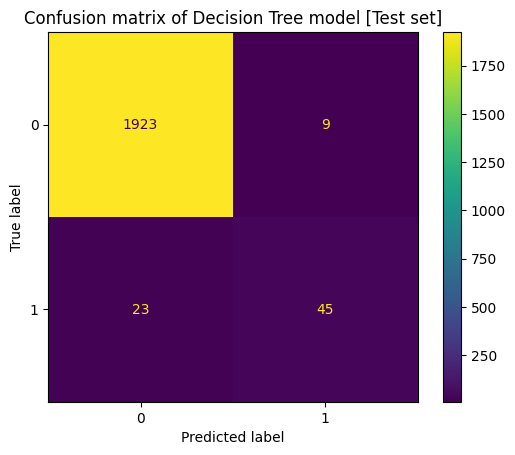

In [57]:
plot_confusion_matrix(dt_pipeline, 'Decision Tree' , X_test,Y_test)

# Random Forest

In [58]:
rf_model = RandomForestClassifier(max_depth=8 ,  random_state=42)

In [59]:
rf_pipeline = make_pipeline(cat_transformer, rf_model)
rf_pipeline.fit(X_train, Y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Evaluate on train set

In [60]:
rf_train_error = get_errors(rf_pipeline, X_train, Y_train)
rf_train_error

{'accuracy ': 0.985625, 'recall ': 0.5756457564575646, 'precision ': 1.0}

### get cv error 

In [61]:
rf_cv_error = cross_validate(rf_pipeline, X_train,Y_train, scoring=get_errors , n_jobs=-1 , cv=5)
rf_cv_error

{'fit_time': array([0.78463817, 0.80684185, 0.77009463, 0.78517365, 0.5548501 ]),
 'score_time': array([0.0445869 , 0.05514264, 0.04055905, 0.04855561, 0.03094816]),
 'test_accuracy ': array([0.975   , 0.976875, 0.978125, 0.978125, 0.975625]),
 'test_recall ': array([0.31481481, 0.31481481, 0.40740741, 0.37037037, 0.32727273]),
 'test_precision ': array([0.85      , 1.        , 0.88      , 0.95238095, 0.9       ])}

In [62]:
rf_avg_cv_error = get_avg_cv_errors(rf_cv_error)
rf_avg_cv_error

{'accuracy ': np.float64(0.97675),
 'recall ': np.float64(0.34693602693602693),
 'precision ': np.float64(0.9164761904761904)}

### Evaluate on test set

In [63]:
rf_pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

In [64]:
rf_test_error  = get_errors(rf_pipeline, X_test ,Y_test)
rf_test_error

{'accuracy ': 0.9765, 'recall ': 0.3382352941176471, 'precision ': 0.92}

In [65]:
log_errors("Rf_Model", rf_train_error.values(), "train", perf_df)
log_errors("Rf_Model", rf_avg_cv_error.values(), "cv", perf_df)
log_errors("Rf_Model", rf_test_error.values(), "test", perf_df)

In [66]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92


## plot confusion matrix for random forest model 

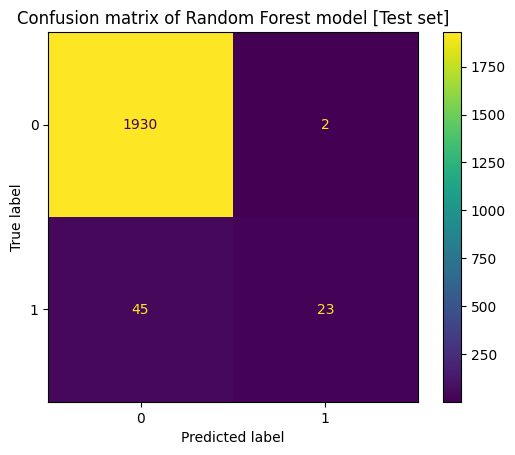

In [67]:
plot_confusion_matrix(rf_pipeline,'Random Forest' , X_test, Y_test)

# Gradient Boosting Model 

In [68]:
gb_model = GradientBoostingClassifier(max_depth=8 , random_state=42)

In [69]:
gb_pipeline = make_pipeline(cat_transformer, gb_model)
gb_pipeline.fit(X_train, Y_train)

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### get Train error

In [70]:
gb_train_error  = get_errors(gb_pipeline, X_train,Y_train)
gb_train_error

{'accuracy ': 1.0, 'recall ': 1.0, 'precision ': 1.0}

### get cross validation error

In [71]:
gb_cv_error = cross_validate(gb_pipeline, X_train, Y_train, cv=5 , scoring=get_errors , n_jobs=-1)
gb_cv_error

{'fit_time': array([3.40459871, 3.50085807, 3.40974903, 3.41584563, 2.18451381]),
 'score_time': array([0.02631259, 0.01418114, 0.02729726, 0.02827072, 0.01050782]),
 'test_accuracy ': array([0.98375 , 0.98375 , 0.985625, 0.983125, 0.98625 ]),
 'test_recall ': array([0.64814815, 0.66666667, 0.72222222, 0.72222222, 0.69090909]),
 'test_precision ': array([0.83333333, 0.81818182, 0.82978723, 0.76470588, 0.88372093])}

In [72]:
gb_avg_cv_error =  get_avg_cv_errors(gb_cv_error)
gb_avg_cv_error

{'accuracy ': np.float64(0.9845),
 'recall ': np.float64(0.6900336700336701),
 'precision ': np.float64(0.8259458396286409)}

### Evaluate on test set 

In [73]:
gb_pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

In [74]:
gb_test_error = get_errors(gb_pipeline, X_test,Y_test)
gb_test_error

{'accuracy ': 0.987, 'recall ': 0.7205882352941176, 'precision ': 0.875}

### Log errors

In [75]:
log_errors("Gb_Model", gb_train_error.values(), "train", perf_df)
log_errors("Gb_Model", gb_avg_cv_error.values(), "cv", perf_df)
log_errors("Gb_Model", gb_test_error.values(), "test", perf_df)

In [76]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92
Gb_Model,1.0,1.0,1.0,0.9845,0.690034,0.825946,0.987,0.720588,0.875


## Find the optimal learning rate for GB model 

In [77]:
gb_pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat_encoder',
                                   OneHotEncoder(drop='if_binary',
                                                 sparse_output=False),
                                   ['type'])],
                    verbose_feature_names_out=False)),
 ('gradientboostingclassifier',
  GradientBoostingClassifier(max_depth=8, random_state=42))]

In [78]:
param_grid =  {'gradientboostingclassifier__learning_rate': np.linspace(0.001,0.01,10) ,'gradientboostingclassifier__n_estimators': [300]
 }  
grid_search_cv =  GridSearchCV(
    gb_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=["accuracy", "recall", "precision"],
    return_train_score=True,
    refit='recall'

)
grid_search_cv.fit(X_train,Y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'gradientboostingclassifier__learning_rate': array([0.001,... 0.01 ]), 'gradientboostingclassifier__n_estimators': [300]}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,-1
,refit,'recall'
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat_encoder', ...)]"


In [79]:

cv_results = pd.DataFrame(grid_search_cv.cv_results_)

In [80]:
cv_cols = [
    "param_gradientboostingclassifier__learning_rate",
    "param_gradientboostingclassifier__n_estimators",
    "mean_test_recall",
    "mean_test_precision",
    "mean_test_accuracy",
    "mean_train_recall",
    "rank_test_recall",
    
    "mean_train_accuracy",
   
    "mean_train_precision",
]
cv_results_subset = cv_results[cv_cols].sort_values(["rank_test_recall"])

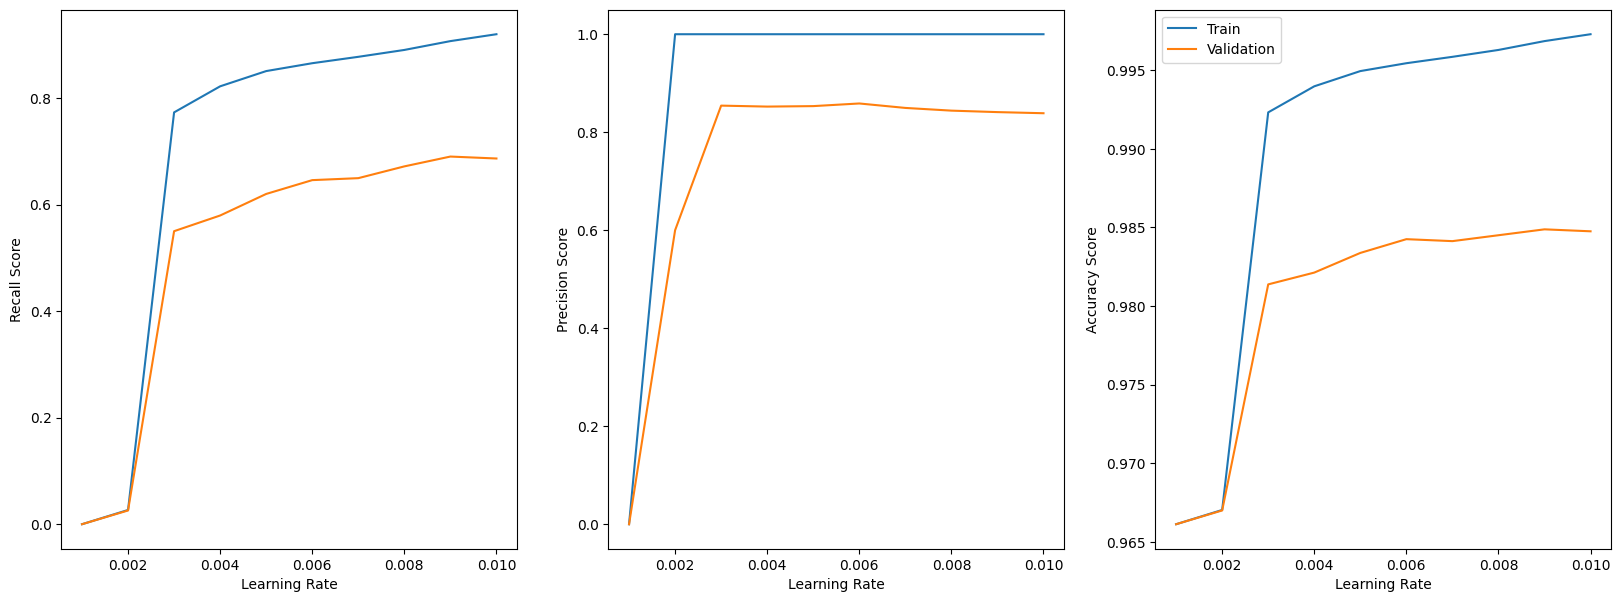

In [81]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_recall"], label="Train")
ax1.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_recall"], label="Validation")
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Recall Score")

ax2.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_precision"], label="Train")
ax2.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_precision"], label="Validation")
ax2.set_xlabel("Learning Rate")
ax2.set_ylabel("Precision Score")

ax3.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_accuracy"], label="Train")
ax3.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_accuracy"], label="Validation")
ax3.set_xlabel("Learning Rate")
ax3.set_ylabel("Accuracy Score")
plt.legend()

In [82]:
cv_results_subset.sort_values("param_gradientboostingclassifier__learning_rate")

,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__n_estimators,mean_test_recall,mean_test_precision,mean_test_accuracy,mean_train_recall,rank_test_recall,mean_train_accuracy,mean_train_precision
0,0.001,300,0.000000,0.000000,0.966125,0.000000,10,0.966125,0.0
1,0.002,300,0.025791,0.600000,0.967000,0.026745,9,0.967031,1.0
2,0.003,300,0.550034,0.854286,0.981375,0.773029,8,0.992312,1.0
3,0.004,300,0.579461,0.852305,0.982125,0.821945,7,0.993969,1.0
4,0.005,300,0.619933,0.853283,0.983375,0.850555,6,0.994938,1.0
5,0.006,300,0.645859,0.858672,0.984250,0.865310,5,0.995438,1.0
6,0.007,300,0.649562,0.849586,0.984125,0.877300,4,0.995844,1.0
7,0.008,300,0.671650,0.844057,0.984500,0.890212,3,0.996281,1.0
8,0.009,300,0.690101,0.841047,0.984875,0.906802,1,0.996844,1.0
9,0.010,300,0.686465,0.838764,0.984750,0.919726,2,0.997281,1.0


## Retain the model with a learning rate of 0.008

In [83]:
gb_model_2 = GradientBoostingClassifier(learning_rate=0.004 , random_state=42 , n_estimators=300, max_depth=8)


In [84]:
gb_pipeline_2 =  make_pipeline(cat_transformer, gb_model_2)
gb_pipeline_2.fit(X_train, Y_train)

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Evaluate the model 

In [85]:
gb_train_error = get_errors(gb_pipeline_2, X_train,Y_train)
gb_train_error

{'accuracy ': 0.993, 'recall ': 0.7933579335793358, 'precision ': 1.0}

### Get cv error 

In [86]:
gb_cv_error = cross_validate(gb_pipeline_2, X_train,Y_train, cv=5 , scoring=get_errors, n_jobs=-1)
gb_cv_error

{'fit_time': array([9.07584643, 9.00355816, 8.95455194, 8.81944013, 5.79955029]),
 'score_time': array([0.02639365, 0.04142523, 0.03749514, 0.03908682, 0.022645  ]),
 'test_accuracy ': array([0.98375 , 0.98    , 0.9825  , 0.98125 , 0.983125]),
 'test_recall ': array([0.62962963, 0.46296296, 0.64814815, 0.61111111, 0.54545455]),
 'test_precision ': array([0.85      , 0.89285714, 0.79545455, 0.78571429, 0.9375    ])}

In [87]:
gb_avg_cv_error = get_avg_cv_errors(gb_cv_error)
gb_avg_cv_error

{'accuracy ': np.float64(0.9821250000000001),
 'recall ': np.float64(0.5794612794612795),
 'precision ': np.float64(0.8523051948051947)}

### Evaluate on test set

In [88]:
gb_test_error = get_errors(gb_pipeline_2, X_test,Y_test)
gb_test_error

{'accuracy ': 0.9845,
 'recall ': 0.6323529411764706,
 'precision ': 0.8775510204081632}

## Log Error 

In [89]:
log_errors("Opt GB Model", gb_train_error.values(), "train", perf_df)
log_errors("Opt GB Model", gb_avg_cv_error.values(), "cv", perf_df)
log_errors("Opt GB Model", gb_test_error.values(), "test", perf_df)

In [90]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92
Gb_Model,1.0,1.0,1.0,0.9845,0.690034,0.825946,0.987,0.720588,0.875
Opt GB Model,0.993,0.793358,1.0,0.982125,0.579461,0.852305,0.9845,0.632353,0.877551


### Plot confusion matrix for Optimax GB model

Text(0.5, 1.0, 'GB model ')

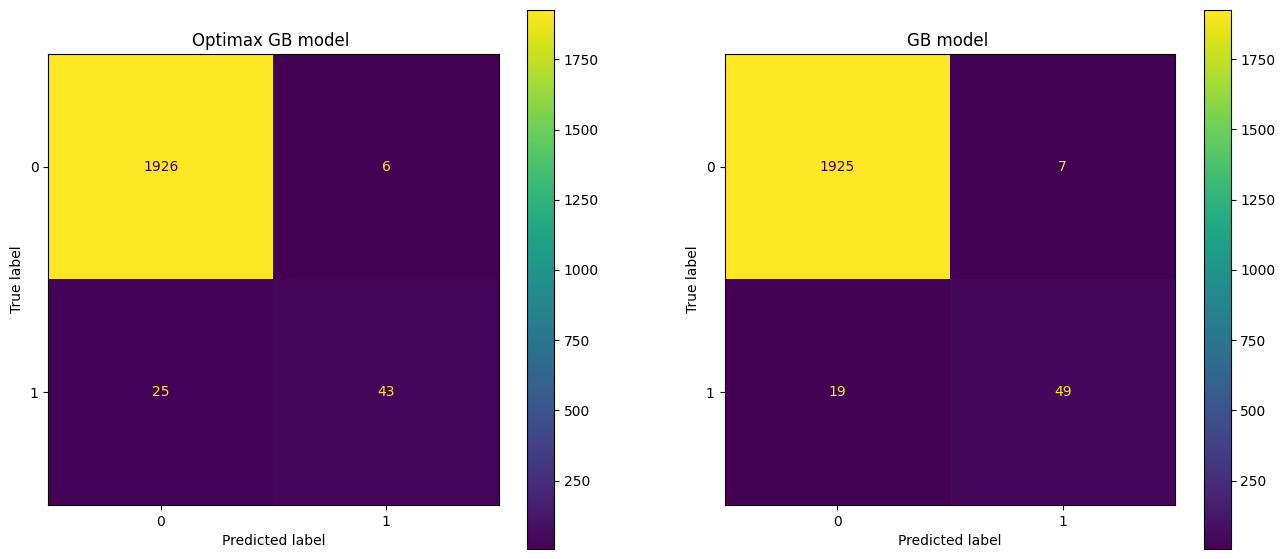

In [91]:
fig, ax = plt.subplots(1,2, figsize= (16,7) )
ConfusionMatrixDisplay.from_estimator(gb_pipeline_2,   X_test, Y_test , ax =ax[0])
ax[0].set_title('Optimax GB model ')
ConfusionMatrixDisplay.from_estimator(gb_pipeline,   X_test, Y_test , ax = ax[1])
ax[1].set_title('GB model ' )


## Add Kmeans Features to GB model 

In [92]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion


In [93]:
kmeans_pipe = make_pipeline(
    cat_transformer,
    StandardScaler(),
    KMeans(4 , random_state=42)
)

In [94]:
feat_union = FeatureUnion(
    [
        ('base_feat' ,  cat_transformer),
        ('kmeans_feat' , kmeans_pipe),
    ],
    verbose_feature_names_out =False
)

In [95]:
gb_kmeans_pipeline = make_pipeline(
    feat_union,
    gb_model_2
)


In [96]:
gb_kmeans_pipeline.fit(X_train,Y_train)

,steps,"[('featureunion', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('base_feat', ...), ('kmeans_feat', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,categories,'auto'
,drop,'if_binary'


## Evaluate the training set 

In [97]:
gb_kmeans_train_errors = get_errors(gb_kmeans_pipeline,X_train,Y_train)
gb_kmeans_train_errors

{'accuracy ': 0.993, 'recall ': 0.7933579335793358, 'precision ': 1.0}

### Get gb_kmeans CV errors

In [98]:
gb_kmeans_cv_errors = cross_validate(gb_kmeans_pipeline, X_train, Y_train, cv=5 , n_jobs=-1, scoring=get_errors)
gb_kmeans_avg_cv_errors =  get_avg_cv_errors(gb_kmeans_cv_errors)
gb_kmeans_avg_cv_errors

{'accuracy ': np.float64(0.981625),
 'recall ': np.float64(0.5721212121212121),
 'precision ': np.float64(0.8400035236081749)}

### Get Test error 

In [99]:
gb_kmeans_test_errors =  get_errors(gb_kmeans_pipeline, X_test,Y_test)
gb_kmeans_test_errors

{'accuracy ': 0.983,
 'recall ': 0.6029411764705882,
 'precision ': 0.8541666666666666}

## Log Errors

In [100]:
log_errors("Opt GB+KM Model", gb_kmeans_train_errors.values(), "train", perf_df)
log_errors("Opt GB+KM Model", gb_kmeans_avg_cv_errors.values(), "cv", perf_df)
log_errors("Opt GB+KM Model", gb_kmeans_test_errors.values(), "test", perf_df)

In [101]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92
Gb_Model,1.0,1.0,1.0,0.9845,0.690034,0.825946,0.987,0.720588,0.875
Opt GB Model,0.993,0.793358,1.0,0.982125,0.579461,0.852305,0.9845,0.632353,0.877551
Opt GB+KM Model,0.993,0.793358,1.0,0.981625,0.572121,0.840004,0.983,0.602941,0.854167


## Plot Confusion Matrix for Kmeans GB model

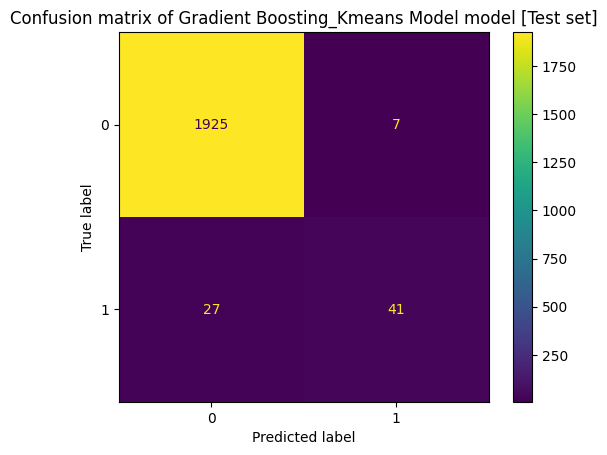

In [102]:
plot_confusion_matrix(gb_kmeans_pipeline, 'Gradient Boosting_Kmeans Model', X_test,Y_test)

# Visulize Feature Importances 

In [103]:
feats_imp = pd.Series(
    gb_kmeans_pipeline[-1].feature_importances_,
    index=gb_kmeans_pipeline[-1].feature_names_in_,

).sort_values()

In [104]:
def clean_feat_name(feature):
    if '__' in feature:
        return feature[feature.index('__')+2:]
    return feature

[Text(0, 0, 'type_M'),
 Text(0, 1, 'type_L'),
 Text(0, 2, 'type_H'),
 Text(0, 3, 'kmeans1'),
 Text(0, 4, 'kmeans3'),
 Text(0, 5, 'kmeans2'),
 Text(0, 6, 'kmeans0'),
 Text(0, 7, 'rotational_speed_[rpm]'),
 Text(0, 8, 'tool_wear_[min]'),
 Text(0, 9, 'process_temp'),
 Text(0, 10, 'air_temperature'),
 Text(0, 11, 'torque_[nm]')]

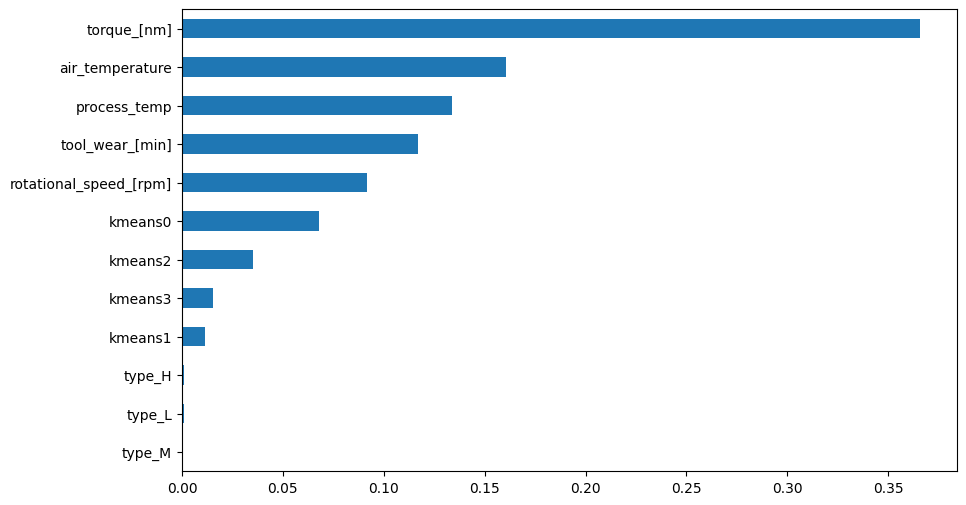

In [105]:
ax = feats_imp.plot(kind="barh", figsize=(10, 6))
ax.set_yticklabels(feats_imp.index.map(clean_feat_name))

Torque and air_temperature seems to be the most significant feature determining if a machine will fail , 4 of the kmeans label features seems to be significantly importace 

# Handle Class Imbalance 

# **Using Opt Gb Model as my threshold optimazation since it perfomance best on all set**

In [106]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92
Gb_Model,1.0,1.0,1.0,0.9845,0.690034,0.825946,0.987,0.720588,0.875
Opt GB Model,0.993,0.793358,1.0,0.982125,0.579461,0.852305,0.9845,0.632353,0.877551
Opt GB+KM Model,0.993,0.793358,1.0,0.981625,0.572121,0.840004,0.983,0.602941,0.854167


<!-- # Using Optimize Gradient Boosting since it preform best on test set  -->


## Find The Optimal Probability Threshold

In [107]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [108]:
ttcv = TunedThresholdClassifierCV(gb_pipeline_2, cv=5, n_jobs=-1 )
ttcv.fit(X_train,Y_train)

,estimator,Pipeline(step...m_state=42))])
,scoring,'balanced_accuracy'
,response_method,'auto'
,thresholds,100
,cv,5
,refit,True
,n_jobs,-1
,random_state,None
,store_cv_results,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'


## Get Train error 

In [109]:
ttcv_train_error = get_errors(ttcv,X_train,Y_train)
ttcv_train_error

{'accuracy ': 0.922625,
 'recall ': 0.977859778597786,
 'precision ': 0.30182232346241455}

### Evaluate on Cross Validation

In [110]:
ttcv_results = cross_validate(
    ttcv, X_train, Y_train, scoring= get_errors , cv=5, n_jobs=-1
)
ttcv_cv_errors = get_avg_cv_errors(ttcv_results)
ttcv_cv_errors

{'accuracy ': np.float64(0.9291250000000002),
 'recall ': np.float64(0.8817508417508417),
 'precision ': np.float64(0.310488827684796)}

### Get Test Error 

In [111]:
ttcv_test_error = get_errors(ttcv, X_test,Y_test)
ttcv_test_error

{'accuracy ': 0.9095,
 'recall ': 0.8823529411764706,
 'precision ': 0.2575107296137339}

### Plot Confusion Matrix Display 

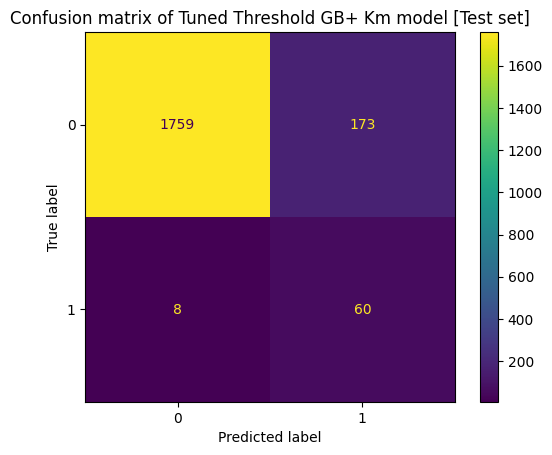

In [112]:
plot_confusion_matrix(ttcv, 'Tuned Threshold GB+ Km', X_test, Y_test)

## Log Error

In [113]:
log_errors("Opt GB+TTCV Model", ttcv_train_error.values(), "train", perf_df)
log_errors("Opt GB+TTCV Model", ttcv_cv_errors.values(), "cv", perf_df)
log_errors("Opt GB+TTCV Model", ttcv_test_error.values(), "test", perf_df)

In [114]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base_model,0.966125,0.0,0.0,0.966125,0.0,0.0,0.966,0.0,0.0
Lg_Model,0.968125,0.062731,0.944444,0.968,0.055354,1.0,0.9665,0.029412,0.666667
Dt_Model,0.990375,0.738007,0.970874,0.9815,0.631246,0.781321,0.984,0.661765,0.833333
Rf_Model,0.985625,0.575646,1.0,0.97675,0.346936,0.916476,0.9765,0.338235,0.92
Gb_Model,1.0,1.0,1.0,0.9845,0.690034,0.825946,0.987,0.720588,0.875
Opt GB Model,0.993,0.793358,1.0,0.982125,0.579461,0.852305,0.9845,0.632353,0.877551
Opt GB+KM Model,0.993,0.793358,1.0,0.981625,0.572121,0.840004,0.983,0.602941,0.854167
Opt GB+TTCV Model,0.922625,0.97786,0.301822,0.929125,0.881751,0.310489,0.9095,0.882353,0.257511


## Retrain The Whole Dataset

In [115]:
ttcv.fit(X,y)

,estimator,Pipeline(step...m_state=42))])
,scoring,'balanced_accuracy'
,response_method,'auto'
,thresholds,100
,cv,5
,refit,True
,n_jobs,-1
,random_state,None
,store_cv_results,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'


In [116]:
get_errors(ttcv,X,y)

{'accuracy ': 0.9269,
 'recall ': 0.9705014749262537,
 'precision ': 0.31333333333333335}

In [117]:
import joblib

In [118]:
joblib.dump(ttcv,'../models/predictive_maintance.Pk1')

['../models/predictive_maintance.Pk1']

## Load the model and test

In [119]:
model = joblib.load('../models/predictive_maintance.Pk1')

In [120]:
get_errors(model,X,y)

{'accuracy ': 0.9269,
 'recall ': 0.9705014749262537,
 'precision ': 0.31333333333333335}

In [121]:
df.iloc[50:60]

,type,air_temperature,process_temp,rotational_speed_[rpm],torque_[nm],tool_wear_[min],target,failure_type
50,L,298.9,309.1,2861,4.6,143,1,power failure
51,L,298.9,309.1,1383,54.9,145,0,no failure
52,H,298.8,309.0,1497,43.8,147,0,no failure
53,L,298.7,309.0,1565,35.1,152,0,no failure
54,L,298.7,309.0,1691,30.1,154,0,no failure
55,L,298.8,309.1,1512,40.7,156,0,no failure
56,L,298.8,309.1,1477,42.4,158,0,no failure
57,L,298.8,309.1,1513,40.3,160,0,no failure
58,M,298.8,309.0,1661,29.5,162,0,no failure
59,L,298.8,309.1,1378,54.4,165,0,no failure


In [122]:
model.predict(X.iloc[50:60])

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])